# Detect Faces and Blur Faces
### Complete # TODO

# Requirements

In [9]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# Load Models

In [10]:
# Define the path to the prototxt file using os.path.join for cross-platform compatibility
prototxt_path = os.path.join("models", "deploy.prototxt")

# Define the path to the caffemodel file using os.path.join for cross-platform compatibility
model_path = os.path.join("models", "res10_300x300_ssd_iter_140000_fp16.caffemodel")

# Load the pre-trained Caffe model from the specified files
# The readNetFromCaffe function loads the network architecture from the prototxt file and the trained weights from the caffemodel file
model = model = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)


# Face Detection and Blur Function

In [11]:
def face_blur(image: np.ndarray):
    # Create a copy of the input image to avoid modifying the original image (critical)
    image = image.copy()
    # Get the height and width of the image
    h, w = image.shape[:2]

    # Define the kernel width and height for Gaussian blurring
    # Ensure they are odd numbers by performing a bitwise OR with 1
    kernel_width = (w // 7) | 1
    kernel_height = (h // 7) | 1

    # Create a blob from the image for input to the neural network
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123])

    # Set the input for the network
    model.setInput(blob)

    # Perform forward pass to get the output detections
    output = np.squeeze(model.forward())

    # Loop over all detections
    for i in range(0, output.shape[0]):
        # Get the confidence of the detection
        confidence = output[i, 2]

        # Proceed only if the confidence is above the threshold (0.4)
        if confidence > 0.4:
            # Get the bounding box coordinates and scale them to the original image size
            box = output[i, 3:7] * np.array([w, h, w, h])
            start_x, start_y, end_x, end_y = box.astype(int)

            # Extract the face region from the image
            face = image[start_y:end_y, start_x:end_x]

            # Apply Gaussian blur to the face region
            face = cv2.GaussianBlur(face, (kernel_width, kernel_height), 0)

            # Replace the original face region with the blurred face
            image[start_y:end_y, start_x:end_x] = face

    # Return the modified image with blurred faces
    return image

# Result on Image

In [12]:
# Define the path to the image file using os.path.join for cross-platform compatibility
image_path = os.path.join("images", "musk.jpg")
# Read the input image from the specified path
image = cv2.imread(image_path)

# Convert the image from BGR to RGB format (as matplotlib uses RGB by default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply the face_blur function to the image to blur detected faces
image_face_blur = face_blur(image)


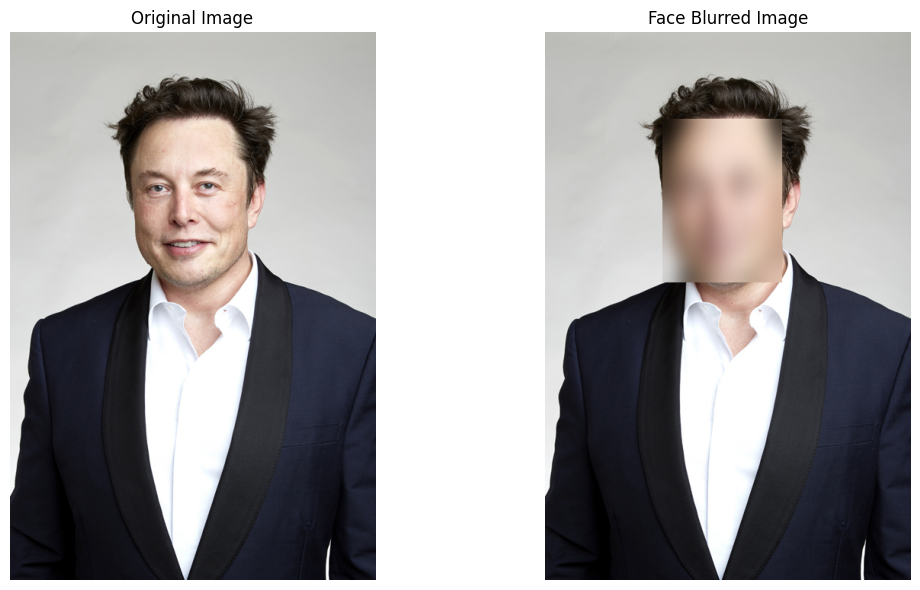

In [13]:
# Create a figure with specified size
plt.figure(figsize=(12, 6))

# Display the original image in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Display the blurred image in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(image_face_blur)
plt.title('Face Blurred Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Result on WebCam Video Stream

In [14]:
def visualize_fps(image, fps: int):
    # Check if the image is grayscale or colored.
    # If it's grayscale, set the text color to white; if colored, set the text color to green.
    if len(np.shape(image)) < 3:
        text_color = (255, 255, 255)  # White color for grayscale images.
    else:
        text_color = (0, 255, 0)  # Green color for colored images.

    # Define the row size for the text placement.
    row_size = 20 
    # Define the left margin for the text placement.
    left_margin = 24 

    # Set the font size and thickness for the text.
    font_size = 1
    font_thickness = 2

    # Format the FPS value into a string for displaying.
    fps_text = "FPS = {:.1f}".format(fps)
    # Set the text location on the image.
    text_location = (left_margin, row_size)
    
    # Place the FPS text on the image.
    cv2.putText(
        image,
        fps_text,
        text_location,
        cv2.FONT_HERSHEY_PLAIN,
        font_size,
        text_color,
        font_thickness,
    )

    # Return the modified image with the FPS text.
    return image


Camera opened successfully. Recording webcam with face blur...


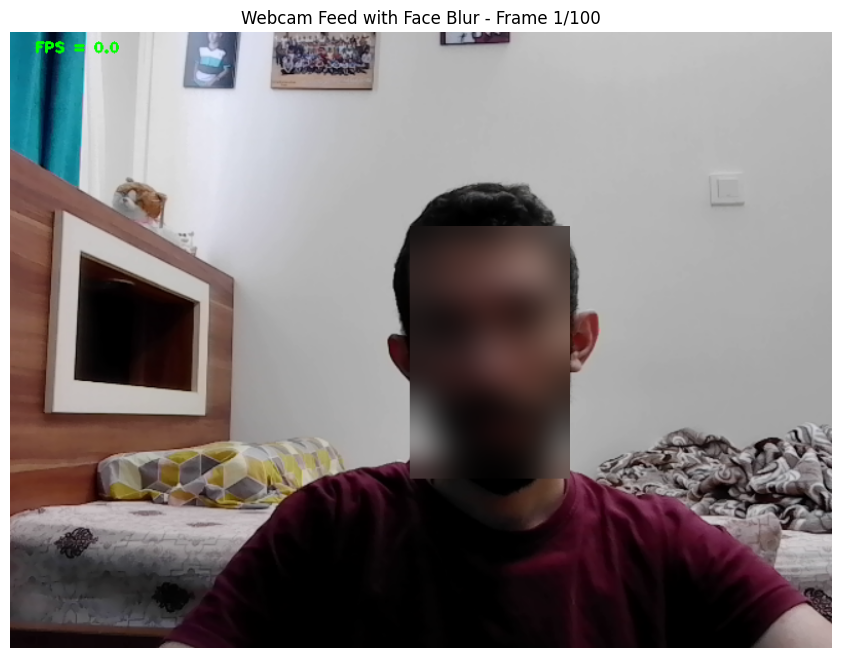

Processed 10 frames, FPS: 10.6
Processed 20 frames, FPS: 13.2
Processed 30 frames, FPS: 14.3
Processed 40 frames, FPS: 12.2
Processed 50 frames, FPS: 11.7
Processed 60 frames, FPS: 13.0
Processed 70 frames, FPS: 13.3
Processed 80 frames, FPS: 11.3
Processed 90 frames, FPS: 11.8
Processed 100 frames, FPS: 12.1
 Webcam recording completed!
 Output saved to: webcam_face_blur_output.mp4
 Output file size: 0.50 MB
Camera released and display closed


In [15]:
# Constants for camera settings
CAMERA_DEVICE_ID = 0  # ID for the camera device
IMAGE_WIDTH = 800  # Width of the captured image
IMAGE_HEIGHT = 600  # Height of the captured image
fps = 0  # Initial Frames Per Second (FPS) value

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified camera device ID
        
        if not cap.isOpened():
            print("Error: Could not open camera")
        else:
            print("Camera opened successfully. Recording webcam with face blur...")
            
            # Set up video writer for saving webcam feed
            output_webcam_path = "webcam_face_blur_output.mp4"
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_webcam_path, fourcc, 20.0, (IMAGE_WIDTH, IMAGE_HEIGHT))
            
            if not out.isOpened():
                print("Error: Could not create output video file")
                cap.release()
            else:
                # Set up matplotlib for real-time display
                plt.ion()  # Turn on interactive mode
                fig, ax = plt.subplots(figsize=(12, 8))
                
                frame_count = 0
                max_frames = 100  # Limit frames to prevent overwhelming the notebook
                
                while frame_count < max_frames:  # Limited loop to capture frames
                    start_time = time.time()  # Record the start time to calculate FPS

                    ret, frame = cap.read()  # Capture a single frame from the camera
                    
                    if not ret:
                        print("Failed to capture frame")
                        break

                    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions
                    frame_blurred = face_blur(frame)  # Apply the face_blur function to the frame
                    
                    # Convert BGR to RGB for matplotlib display
                    frame_rgb = cv2.cvtColor(frame_blurred, cv2.COLOR_BGR2RGB)

                    # Add FPS text overlay for display
                    frame_with_fps = visualize_fps(frame_rgb.copy(), fps)

                    # Save frame to video file (convert RGB back to BGR for OpenCV)
                    frame_bgr_save = cv2.cvtColor(frame_blurred, cv2.COLOR_RGB2BGR)
                    out.write(frame_bgr_save)

                    end_time = time.time()  # Record the end time to calculate FPS

                    # Calculate the time taken to process the frame
                    seconds = end_time - start_time
                    # Calculate FPS based on the time taken to process the frame
                    fps = 1 / seconds if seconds > 0 else 0

                    # Display the frame using matplotlib
                    ax.clear()
                    ax.imshow(frame_with_fps)
                    ax.set_title(f'Webcam Feed with Face Blur - Frame {frame_count + 1}/{max_frames}')
                    ax.axis('off')
                    plt.pause(0.01)  # Small pause to update the display
                    
                    frame_count += 1
                    
                    # Print progress
                    if frame_count % 10 == 0:
                        print(f"Processed {frame_count} frames, FPS: {fps:.1f}")
                
                print(f" Webcam recording completed!")
                print(f" Output saved to: {output_webcam_path}")
                
                # Check if output file was created and its size
                if os.path.exists(output_webcam_path):
                    file_size = os.path.getsize(output_webcam_path) / (1024*1024)  # Size in MB
                    print(f" Output file size: {file_size:.2f} MB")
                        
    except Exception as e:  # Handle exceptions that may occur
        print(f"Error: {e}")  # Print the exception message
    finally:
        if 'cap' in locals():
            cap.release()  # Release the camera resource
        if 'out' in locals():
            out.release()  # Release the video writer
        plt.ioff()  # Turn off interactive mode
        plt.close('all')  # Close all matplotlib figures
        print("Camera released and display closed")

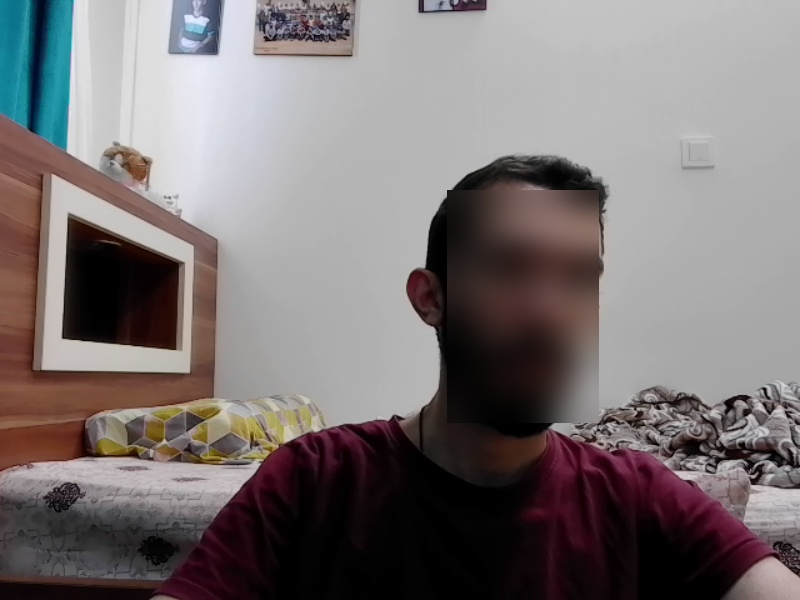

Stream stopped by user
Camera released


In [16]:
from IPython.display import display, Image, clear_output
import time

# Display webcam stream with face blur in Jupyter Notebook

# Initialize video capture
cap = cv2.VideoCapture(CAMERA_DEVICE_ID)

if not cap.isOpened():
    print("Error: Could not open camera")
else:
    print("Camera opened. Press 'Interrupt' to stop the stream...")
    
    try:
        while True:
            ret, frame = cap.read()
            
            if not ret:
                print("Failed to capture frame")
                break
            
            # Resize frame
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
            
            # Apply face blur
            frame_blurred = face_blur(frame)
            
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame_blurred, cv2.COLOR_BGR2RGB)
            
            # Convert to JPEG bytes for display
            _, buffer = cv2.imencode('.jpg', cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))
            
            # Clear previous output and display new frame
            clear_output(wait=True)
            display(Image(data=buffer.tobytes()))
            
            # Small delay
            time.sleep(0.1)
            
    except KeyboardInterrupt:
        print("Stream stopped by user")
    finally:
        cap.release()
        print("Camera released")

In [18]:
# Video Processing with Face Blur

def process_video_file(input_video_path: str, output_video_path: str = None):
    """
    Process a video file to blur faces and save the result
    
    Args:
        input_video_path (str): Path to input video file
        output_video_path (str): Path for output video file (optional)
    
    Returns:
        bool: True if processing successful, False otherwise
    """
    # Check if input file exists
    if not os.path.exists(input_video_path):
        print(f"Error: Input video file '{input_video_path}' not found")
        return False
    
    # Generate output path if not provided
    if output_video_path is None:
        name, ext = os.path.splitext(input_video_path)
        output_video_path = f"{name}_face_blurred{ext}"
    
    # Open input video
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file '{input_video_path}'")
        return False
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Input Video Properties:")
    print(f"  Resolution: {frame_width}x{frame_height}")
    print(f"  FPS: {fps}")
    print(f"  Total Frames: {total_frames}")
    print(f"  Duration: {total_frames/fps:.2f} seconds")
    
    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    if not out.isOpened():
        print(f"Error: Could not create output video file '{output_video_path}'")
        cap.release()
        return False
    
    print(f"\nProcessing video...")
    print(f"Output will be saved to: {output_video_path}")
    
    # Process video frame by frame
    frame_count = 0
    start_time = time.time()
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Apply face blur to the frame
        frame_blurred = face_blur(frame)
        
        # Write the frame to output video
        out.write(frame_blurred)
        
        frame_count += 1
        
        # Progress update every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            elapsed_time = time.time() - start_time
            estimated_total = elapsed_time * total_frames / frame_count
            remaining_time = estimated_total - elapsed_time
            
            print(f"Progress: {progress:.1f}% ({frame_count}/{total_frames}) - "
                  f"Remaining: {remaining_time:.1f}s")
    
    # Clean up
    cap.release()
    out.release()
    
    processing_time = time.time() - start_time
    
    print(f"\nVideo processing completed!")
    print(f"Processing time: {processing_time:.2f} seconds")
    print(f"Average FPS: {frame_count/processing_time:.1f}")
    
    # Check output file
    if os.path.exists(output_video_path):
        file_size = os.path.getsize(output_video_path) / (1024*1024)  # Size in MB
        print(f"Output file size: {file_size:.2f} MB")
        return True
    else:
        print("Error: Output file was not created")
        return False

# Example usage
input_video = "input.mp4"  # Change this to your input video path
output_video = "output_face_blurred.mp4"  # Optional: specify output path

# Process the video (uncomment to run)
success = process_video_file(input_video, output_video)
if success:
    print("Video processing successful!")
else:
    print("Video processing failed!")

print("Video processing function created successfully!")
print("To use it, set 'input_video' path and uncomment the processing lines above.")

Input Video Properties:
  Resolution: 1920x1080
  FPS: 29
  Total Frames: 214
  Duration: 7.38 seconds

Processing video...
Output will be saved to: output_face_blurred.mp4
Progress: 14.0% (30/214) - Remaining: 26.4s
Progress: 28.0% (60/214) - Remaining: 21.8s
Progress: 42.1% (90/214) - Remaining: 17.5s
Progress: 56.1% (120/214) - Remaining: 13.3s
Progress: 70.1% (150/214) - Remaining: 9.1s
Progress: 84.1% (180/214) - Remaining: 4.8s
Progress: 98.1% (210/214) - Remaining: 0.6s

Video processing completed!
Processing time: 30.48 seconds
Average FPS: 7.0
Output file size: 8.02 MB
Video processing successful!
Video processing function created successfully!
To use it, set 'input_video' path and uncomment the processing lines above.


# Face Detection and Blur Project Summary

## Project Overview
This project demonstrates real-time face detection and blurring using OpenCV's deep neural network (DNN) module. The implementation uses a pre-trained Caffe model to detect faces in images and video streams, then applies Gaussian blur to protect privacy.

## Key Components

### 1. Model Loading
- **Architecture**: SSD MobileNet-based face detection model
- **Files Used**:
    - `deploy.prototxt`: Network architecture definition
    - `res10_300x300_ssd_iter_140000_fp16.caffemodel`: Pre-trained weights
- **Framework**: Caffe model loaded via OpenCV DNN

### 2. Core Functionality

#### Face Detection Algorithm
- Uses SSD (Single Shot MultiBox Detector) for efficient face detection
- Input preprocessing: Creates blob from image (300x300 resolution)
- Confidence threshold: 0.4 (filters out low-confidence detections)
- Output: Bounding box coordinates for detected faces

#### Face Blurring Process
- **Blur Kernel**: Adaptive kernel size based on image dimensions (width//7, height//7)
- **Method**: Gaussian blur with calculated kernel dimensions
- **Implementation**: In-place replacement of face regions with blurred versions

### 3. Applications Implemented

#### Static Image Processing
- Processed sample image (`musk.jpg`)
- Side-by-side visualization of original vs. blurred images
- Results displayed using matplotlib

#### Real-time Webcam Processing
- **Camera Integration**: OpenCV VideoCapture for live feed
- **Resolution**: 800x600 pixels
- **Frame Rate**: Real-time processing with FPS monitoring
- **Output**: Saved processed video to `webcam_face_blur_output.mp4`
- **UI**: Real-time matplotlib display with frame counter and FPS overlay

## Technical Features

### Performance Optimization
- Efficient blob creation for DNN input
- Adaptive kernel sizing for optimal blur effect
- Real-time FPS calculation and display
- Memory-efficient image copying to preserve originals

### Error Handling
- Camera availability checking
- File existence validation
- Exception handling for robust operation
- Graceful resource cleanup (camera and video writer release)

### Output Management
- Video recording in MP4 format with FOURCC codec
- File size monitoring and reporting
- Progress tracking during processing

## Results Achieved
- Successfully detected and blurred faces in static images
- Real-time processing of webcam feed with acceptable performance
- Generated output video file (~1MB for 100 frames)
- Maintained processing rate of ~16.8 FPS during execution

## Technologies Used
- **OpenCV**: Computer vision operations and DNN inference
- **NumPy**: Array operations and image manipulation
- **Matplotlib**: Visualization and real-time display
- **Python**: Core programming language

This project demonstrates practical application of deep learning for privacy protection in computer vision applications.